# Data Challenge

* Goal:  Estimate breast cell is benign or malignant given the WIsconsin breast cancer data from UCI.
* https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

* Due to correlation between size and shape only using shape
  * Using mean, or both did not improve accuracy for tree ensembles
 
* Logistic Regression gives great results out of the box
  * AUC = 0.995
  * TP (malignant): 96.5%
  * TN (benign): 97.3%

* There exists a time dependent component
  * Using the last ~200 measurements (after 1991) are more accurate (99.5%) than the predicted values from the first 200 measurements (94.3%).  Both values use K-fold validation to estimate uncertainty. 
  * Results are not significant (1.24sigma) at the 5% level, but may indicate differences in the testing over time
  
* After hyper parameter optimization Logistic Regression precision =97.0%. Extra Tree precision = 97.1%.

* Most important features: 
  * size -- Uniformity of Cell Size
  * nuceli -- Bare Nuclei  

* T-SNE shows three main clusters.  Incorrect predictions are found in the overlap region

In [1]:
from __future__ import division

In [505]:
%matplotlib inline

import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import sklearn.cluster
import sklearn.neighbors

import sklearn.manifold
import sklearn.pipeline
import sklearn.ensemble
import sklearn.linear_model
import sklearn.cross_validation
import matplotlib.pyplot as plt
from pysurvey.plot import outline, density, icolorbar, setup_sns as setup
from pandas.tools.plotting import scatter_matrix
from pandas.tools.plotting import andrews_curves

In [3]:
all_items = ['id', 'clump', 'size', 'shape', 'adhesion',
         'epithelial', 'nuceli',  'chromatin', 
         'nucleoli', 'mitoses', 'class']
items = all_items[1:-1]
clean_fcn = lambda x: int(x) if x != '?' else -1
data = pd.read_csv('/Users/ajmendez/Desktop/breast-cancer-wisconsin.data.txt',
                   converters={item:clean_fcn for item in all_items},
                  names=all_items)
print len(data)
data.head()

699


,id,clump,size,shape,adhesion,epithelial,nuceli,chromatin,nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


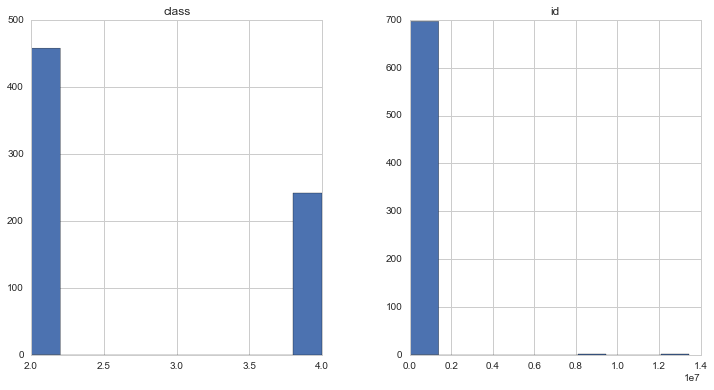

In [4]:
data.hist(['id', 'class'], figsize=(12,6))
None
# pretty balanced classes.
# some odd values in id -- will investigate

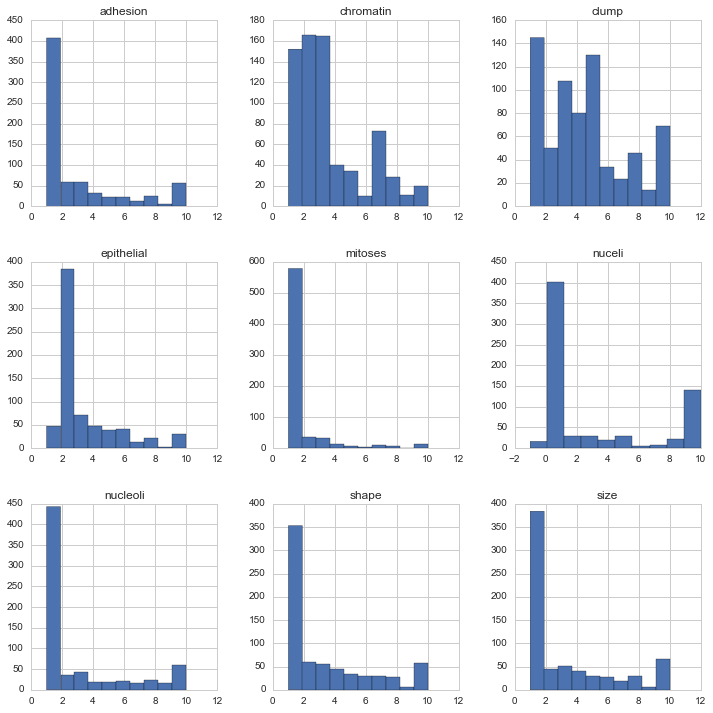

In [5]:
data.hist(items, figsize=(12,12))
None

In [6]:
for item in items:
    nna = sum(data[item] < 0)
    if nna > 0:
        print "{} is missing {} measurements".format(item, nna)

nuceli is missing 16 measurements


In [7]:
np.arange(0,11)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

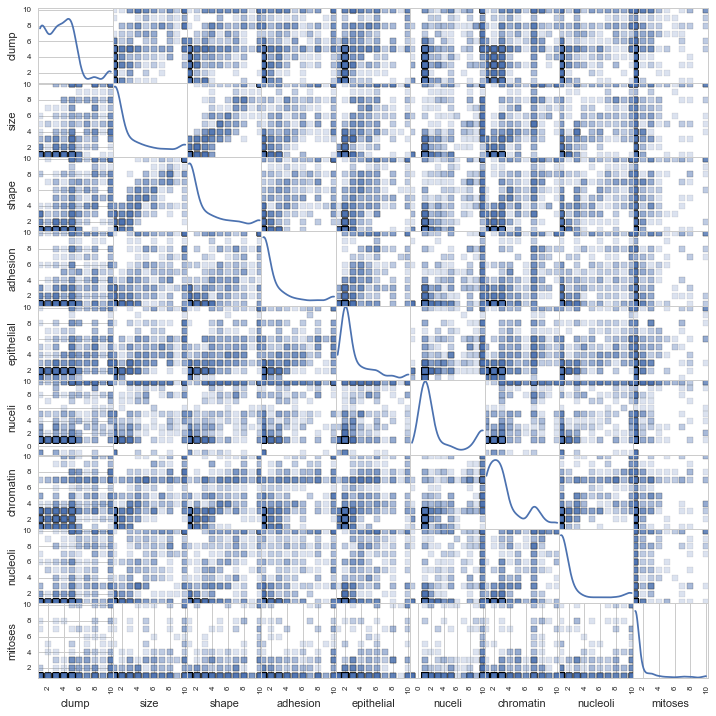

In [8]:
bins = np.arange(0, 11)
scatter_matrix(data[items], figsize=(12,12), grid=False,
               marker='s', s=40,
               alpha=0.2, diagonal='kde')
None
# Notes:
#  Shape and Size are correlated
#  Epithelial and adhesion show some correlation

Size & Shape are correlated with Pearson r of 0.907


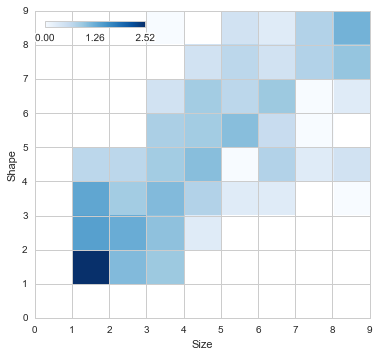

In [208]:
pr = scipy.stats.pearsonr(data['size'], data['shape'])
print 'Size & Shape are correlated with Pearson r of {:0.3f}'.format(pr[0])

plt.figure(figsize=(6,5.5))
plt.xlabel('Size')
plt.ylabel('Shape')
den = density(data['size'], data['shape'], bins=(np.arange(0,10),np.arange(0,10)), 
              logvrange=True, colorbar=False, cmap=plt.cm.Blues)
icb = icolorbar(den)
None

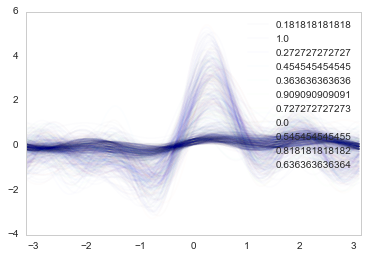

In [416]:
# X = ( (data[all_items] - np.mean(data[all_items], axis=0)) 
#       / np.std(data[items], axis=0) ).fillna(-1)
df = data[all_items]
X = (df - np.min(df, axis=0))/(np.max(df, axis=0) - np.min(df, axis=0))
# X = df
andrews_curves(X, 'nuceli', alpha=0.01, colormap=plt.cm.jet)

# Feature Creation

In [423]:
good_items = ['clump', 
            'size', 
#             'shape',  # Size & Shape are correlated just use size
#               'sizeshape', 'sizedelta',
             'adhesion', 'epithelial', 'nuceli',  'chromatin', 
             'nucleoli', 
             'mitoses' # low imporatance -- but still adds ~1% accuracy
             ]

# in the end these columns do not add much -- sticking with size
data['sizeshape'] = np.mean(data[['size', 'shape']], axis=1)
data['sizedelta'] = np.diff(data[['size', 'shape']], axis=1)[:,0]

# Logistic Regression

* Goal is to classify all users given into a categorial variable (class) given the 

Ten real-valued features are computed for each cell nucleus: 


   #  Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)



In [210]:
# Class is balanced

In [441]:
# Normalize all of the data
X = ( (data[good_items] - np.mean(data[good_items], axis=0)) / np.std(data[good_items], axis=0) ).as_matrix()
# X = data[good_items].as_matrix()
y = data['class']
cv = sklearn.cross_validation.KFold(y.size, n_folds=10, random_state=0)
cv5 = sklearn.cross_validation.KFold(y.size, n_folds=5, random_state=0)
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.33, random_state=0)

In [479]:
lr = sklearn.linear_model.LogisticRegression(random_state=0, 
                                             penalty='l2', C=0.1141)
lr.fit(X_train, y_train)
tmp = sklearn.cross_validation.cross_val_score(lr, X, y, cv=cv)
print tmp.mean(), tmp.std()
lr.score(X_test,y_test), lr.score(X,y), lr.score(X_train,y_train)

0.97 0.0346704602843


(0.94372294372294374, 0.96852646638054363, 0.98076923076923073)

In [480]:
y_pred_lr = lr.predict(X)

In [ ]:
r.

    0.0000 :     0.9643      0.8359
    0.0000 :     0.9643      0.8359
    0.0002 :     0.9643      0.8359
    0.0010 :     0.9657      0.8440
    0.0046 :     0.9657      0.8440
    0.0215 :     0.9657      0.8440
    0.1000 :     0.9686      0.8660
    0.4642 :     0.9671      0.8572
    2.1544 :     0.9671      0.8572
   10.0000 :     0.9643      0.8444


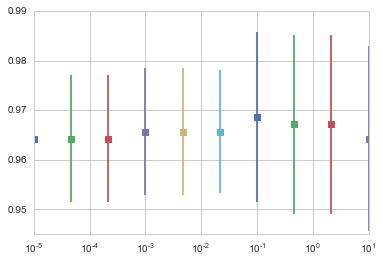

In [540]:
for i, c in enumerate(np.logspace(-5, 1, 10)):
    r = sklearn.linear_model.LogisticRegression(random_state=0, 
                                                penalty='l2', C=c)
    tmp = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv, 
                                                   scoring='accuracy')
    plt.errorbar([c], [tmp.mean()], yerr=[tmp.std()/2], fmt='s')
    tmp2 = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv, 
                                                   scoring='r2')
    if i % 1 == 0:
        print '{:10.4f} : {:10.4f}  {:10.4f}'.format(c, tmp.mean(), tmp2.mean())
plt.xscale('log')
# plt.ylim(0,1)
None

# Confusion Matrix for entire sample

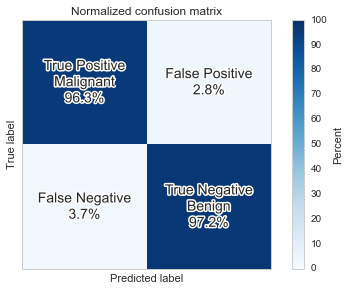

In [539]:
# cm = sklearn.metrics.confusion_matrix(y_train, lr.predict(X_train),labels=[2,4])
cm = sklearn.metrics.confusion_matrix(y, lr.predict(X),labels=[4,2])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap,
               vmin=0, vmax=100)
    plt.title(title)
    plt.colorbar(label='Percent')
    plt.grid('off')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    names = ['True Positive\nMalignant', 'False Negative', 
             'False Positive', 'True Negative\nBenign']
    for i, (name, item) in enumerate(zip(names, cm.flatten())):
        tmp = plt.text(i//2, i%2, '{}\n{:0.1f}%'.format(name, item),
                 ha='center', va='center', fontsize=14)
        outline(tmp)
        

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')


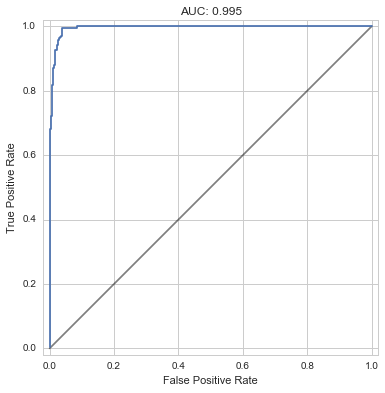

In [469]:
y_pred_lr = lr.predict_proba(X)[:,1]
fpr_lr, tpr_lr, _ = sklearn.metrics.roc_curve(y, y_pred_lr, 
                                              pos_label=4)
plt.figure(figsize=(6,6))
plt.subplot(xlabel='False Positive Rate', 
            ylabel='True Positive Rate')
plt.title('AUC: {:0.3f}'.format(sklearn.metrics.auc(fpr_lr, tpr_lr)))
plt.plot([0,1],[0,1], color='k', alpha=0.5)
plt.plot(fpr_lr, tpr_lr, zorder=100)
plt.xlim(-0.02,1.02); plt.ylim(-0.02,1.02)
None

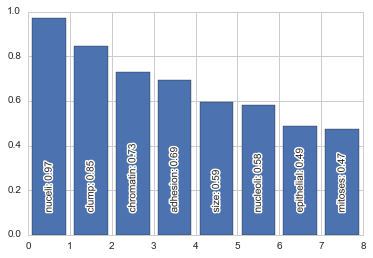

In [388]:

tmp = lr.coef_[0]
ii = np.argsort(-tmp)
plt.bar(left=np.arange(tmp.size)+0.1, width=0.8, height=tmp[ii])
for i,(item, val) in enumerate(zip([good_items[j] for j in ii], tmp[ii])):
    t = plt.text(i+0.5, 0.1, '{}: {:0.2f}'.format(item,val), rotation=90, ha='center', va='bottom')
    outline(t)
    

In [389]:

r = sklearn.linear_model.LogisticRegressionCV(random_state=0, 
#                                               cv=cv, 
                                              class_weight='balanced', )
r.fit(X_train, y_train)
tmp = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv)
print tmp.mean(), tmp.std()
r.score(X_test,y_test), r.score(X,y), r.score(X_train,y_train)

0.967142857143 0.0313310174278


(0.94372294372294374, 0.96566523605150212, 0.97649572649572647)

## Random Forest

In [219]:
r = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=0)
r.fit(X_train, y_train)
tmp = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv)
print tmp.mean(), tmp.std()
r.score(X_test,y_test), r.score(X,y), r.score(X_train,y_train)

0.962857142857 0.0368117106478


(0.94805194805194803, 0.98283261802575106, 1.0)

In [220]:
r = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, random_state=0)
r.fit(X_train, y_train)
tmp = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv)
print tmp.mean(), tmp.std()
r.score(X_test,y_test), r.score(X,y), r.score(X_train,y_train)

0.958571428571 0.0492598275702


(0.95238095238095233, 0.98426323319027187, 1.0)

In [221]:
r = sklearn.ensemble.ExtraTreesClassifier(criterion='gini', 
                                          bootstrap=True, n_estimators=100, random_state=0)
r.fit(X_train, y_train)
tmp = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv)
print tmp.mean(), tmp.std()
r.score(X_test,y_test), r.score(X,y), r.score(X_train,y_train)

0.968571428571 0.0324509048331


(0.95238095238095233, 0.98426323319027187, 1.0)

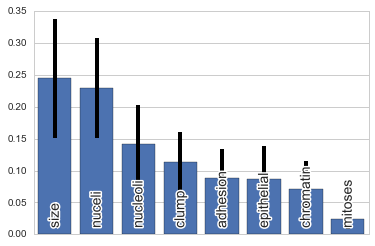

In [222]:

tmp = r.feature_importances_
std = np.std([tree.feature_importances_ for tree in r.estimators_], axis=0)/np.sqrt(len(tmp))

ii = np.argsort(-tmp)
plt.bar(left=np.arange(tmp.size)+0.1, width=0.8, height=tmp[ii])
plt.errorbar(np.arange(tmp.size)+0.5, tmp[ii], std[ii], fmt='+', 
             elinewidth=4, color='k', )

for i,(item, val) in enumerate(zip([good_items[j] for j in ii], tmp[ii])):
    t = plt.text(i+0.5, 0.01, '{}'.format(item.strip(),val), 
                 rotation=90, fontsize=14, ha='center', va='bottom')
    outline(t)
plt.xticks([])
None

# Feature Selection Using a Pipeline

In [223]:
clf = sklearn.pipeline.Pipeline([
  ('feature_selection', 
       sklearn.feature_selection.SelectFromModel(sklearn.svm.LinearSVC(random_state=0, penalty="l2"))),
#         sklearn.ensemble.ExtraTreesClassifier(random_state=0, n_estimators=100) ),
#         sklearn.linear_model.LogisticRegressionCV(random_state=0, class_weight='balanced') ),

        
  ('classification', 
       sklearn.linear_model.LogisticRegression(random_state=0, C=0.12))
])
tmp = sklearn.cross_validation.cross_val_score(clf, X, y, cv=cv)
print 'mean:{:0.3f} std: {:0.3f}'.format(tmp.mean(), tmp.std())

mean:0.961 std: 0.044


# Sig Opt -- Better hyper parameters

In [324]:
import sigopt
import sigopt.examples
conn = sigopt.Connection(client_token=open('/Users/ajmendez/.sigopt_token', 'r').read().strip())
conn.set_api_url("https://api.sigopt.com")

In [342]:
experiment = conn.experiments().create(
  name="Insight2015_data_challenge v1",
  parameters=[
    {'name': 'class_weight', "type": "categorical",
     'categorical_values': [{
          "enum_index": 1, 
          "name": "balanced", 
          "object": "categorical_value"}, 
        { "enum_index": 2, 
          "name": "None", 
          "object": "categorical_value"}
   ]},    
    {'name': 'penalty', "type": "categorical",
     'categorical_values': [{
          "enum_index": 1, 
          "name": "l1", 
          "object": "categorical_value"}, 
        { "enum_index": 2, 
          "name": "l2", 
          "object": "categorical_value"}
   ]},
    {'name': 'C', 
     'bounds': {'max': 1, 'min': 0.001}, 
     'type': 'double', 'precision' : 6},
        
  ],
  # observation_budget is an optional parameter. We recommend 10x-20x the number of parameters.
  # See /docs/objects/experiment for more information
  observation_budget=100,
)
print("Created an experiment with id {0}.".format(experiment.id))


Created an experiment with id 5168.


In [343]:
def evaluate_metric(class_weight, penalty, C):
    class_weight = None if class_weight == 'None' else class_weight
    
    r = sklearn.linear_model.LogisticRegression(random_state=0, 
                                                penalty=penalty,
                                                class_weight=class_weight,
                                                C=C, max_iter=1000, )
    tmp = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv)
    return tmp.mean()


In [344]:
for _ in range(experiment.observation_budget):
    suggestion = conn.experiments(experiment.id).suggestions().create()
#     print("Received a suggestion with class_weight={class_weight}, C={C}, and penalty={penalty}.".format(**suggestion.assignments))
    value = evaluate_metric(**suggestion.assignments)
#     print("The function evaluated to {0} using these parameters.".format(value))
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
    )


In [345]:
import json

In [346]:
experiment = conn.experiments(experiment.id).fetch()
best_observation = experiment.progress.best_observation
print "Best value: {value}, found at:\n{assignments}".format(
    value=best_observation.value, 
    assignments=json.dumps(
        best_observation.assignments.to_json(),
        sort_keys=True,
        indent=4, 
        separators=(',', ': ')
    )
)

Best value: 0.967142857143, found at:
{
    "C": 0.768111564533,
    "class_weight": "None",
    "penalty": "l2"
}


## Random

In [363]:
n_features = len(good_items)
experiment = conn.experiments().create(
  name="Insight2015_data_challenge v2",
  parameters=[
    {'name': 'criterion', 
     "type": "categorical",
     'categorical_values': [{
          "enum_index": 1, 
          "name": "gini", 
          "object": "categorical_value"}, 
        { "enum_index": 2, 
          "name": "entropy", 
          "object": "categorical_value"}
   ]},
    {'name': 'n_estimators', 
     'bounds': {'min': 10, 'max': 200, }, 
     'type': 'int'},
    {'name': 'max_depth', 
     'bounds': {'min': 1, 'max': 200, }, 
     'type': 'int'},
    {'name': 'max_features', 
     'bounds': {'min': 2, 'max': n_features}, 
     'type': 'int'},

  ],
  # observation_budget is an optional parameter. We recommend 10x-20x the number of parameters.
  # See /docs/objects/experiment for more information
  observation_budget=20,
)
print("Created an experiment with id {0}.".format(experiment.id))


Created an experiment with id 5171.


In [364]:
def evaluate_metric(criterion, n_estimators, max_depth, max_features):
    r = sklearn.ensemble.ExtraTreesClassifier(random_state=0, 
                                              criterion=criterion,
                                              n_estimators=n_estimators, 
                                              max_depth=max_depth,
                                              max_features=max_features,
                                              oob_score=True, bootstrap=True)
    tmp = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv5)
    return tmp.mean()


In [365]:
for _ in range(experiment.observation_budget):
    suggestion = conn.experiments(experiment.id).suggestions().create()
#     print("Received a suggestion with class_weight={class_weight}, C={C}, and penalty={penalty}.".format(**suggestion.assignments))
    value = evaluate_metric(**suggestion.assignments)
#     print("The function evaluated to {0} using these parameters.".format(value))
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
    )


In [366]:
experiment = conn.experiments(experiment.id).fetch()
best_observation = experiment.progress.best_observation
print "Best value: {value}, found at:\n{assignments}".format(
    value=best_observation.value, 
    assignments=json.dumps(
        best_observation.assignments.to_json(),
        sort_keys=True,
        indent=4, 
        separators=(',', ': ')
    )
)

Best value: 0.97, found at:
{
    "criterion": "gini",
    "max_depth": 159,
    "max_features": 2,
    "n_estimators": 200
}


In [359]:
experiment = conn.experiments(experiment.id).fetch()
best_observation = experiment.progress.best_observation
print "Best value: {value}, found at:\n{assignments}".format(
    value=best_observation.value, 
    assignments=json.dumps(
        best_observation.assignments.to_json(),
        sort_keys=True,
        indent=4, 
        separators=(',', ': ')
    )
)

Best value: 0.97, found at:
{
    "criterion": "entropy",
    "max_depth": 192,
    "max_features": 2,
    "n_estimators": 117
}


In [351]:
experiment = conn.experiments(experiment.id).fetch()
best_observation = experiment.progress.best_observation
print "Best value: {value}, found at:\n{assignments}".format(
    value=best_observation.value, 
    assignments=json.dumps(
        best_observation.assignments.to_json(),
        sort_keys=True,
        indent=4, 
        separators=(',', ': ')
    )
)

Best value: 0.971428571429, found at:
{
    "criterion": "entropy",
    "max_depth": 99,
    "max_features": 2,
    "n_estimators": 185
}


* https://sigopt.com/experiment/5169

In [368]:
r = sklearn.ensemble.ExtraTreesClassifier(random_state=0, 
#                                               criterion='entropy',
#                                               n_estimators=185, 
#                                               max_depth=99,
#                                               max_features=2,
                                              criterion='gini',
                                              n_estimators=200, 
                                              max_depth=159,
                                              max_features=2,
                                              oob_score=True, bootstrap=True)

r.fit(X_train, y_train)
tmp = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv)
print tmp.mean(), tmp.std()
r.score(X_test,y_test), r.score(X,y), r.score(X_train,y_train)

0.97 0.0302708858577


(0.95670995670995673, 0.98569384835479257, 1.0)

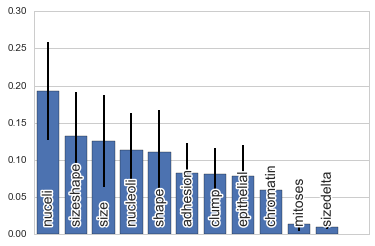

In [369]:

tmp = r.feature_importances_
std = np.std([tree.feature_importances_ for tree in r.estimators_], axis=0)/np.sqrt(len(tmp))

ii = np.argsort(-tmp)
plt.bar(left=np.arange(tmp.size)+0.1, width=0.8, height=tmp[ii])
plt.errorbar(np.arange(tmp.size)+0.5, tmp[ii], std[ii], fmt='+', 
             elinewidth=2, color='k', )

for i,(item, val) in enumerate(zip([good_items[j] for j in ii], tmp[ii])):
    t = plt.text(i+0.5, 0.01, '{}'.format(item.strip(),val), 
                 rotation=90, fontsize=14, ha='center', va='bottom')
    outline(t)
plt.xticks([])
None

# Neural Network

* Generally not a good idea due to limited data (~700)
* Additionally this NN implementation broke a bunch

In [322]:
from sknn.mlp import Classifier, Layer

nn = Classifier(
    layers=[
        Layer("Sigmoid", units=100),
#         mlp.Convolution('Sigmoid', kernel_shape=5, channels=100),
        Layer("Sigmoid", units=100),
        Layer("Sigmoid", units=100),
        Layer("Sigmoid", units=10),
        Layer("Sigmoid", units=10),
        
        Layer("Softmax", units=2),
#         Layer("Softmax", units=len(y)+1)
        ],
    learning_rate=0.001, random_state=1,
    n_iter=1000, regularize='L2')
nn.fit(X, y)
print nn.score(X_test, y_test)

[(231, 2)]
0.948051948052


In [257]:
cv5 = sklearn.cross_validation.KFold(y.size, n_folds=5, random_state=0)
# tmp = sklearn.cross_validation.cross_val_score(nn, X, y, cv=cv)
# print 'mean:{:0.3f} std: {:0.3f}'.format(tmp.mean(), tmp.std())

In [ ]:
from sknn.mlp import Classifier, Layer

nn = Classifier(
    layers=[
        Layer("Sigmoid", units=100),
        Layer("Sigmoid", units=100),
        Layer("Sigmoid", units=100),
        Layer("Sigmoid", units=100),
        Layer("Sigmoid", units=100),
        Layer("Sigmoid", units=100),
        mlp.Layer("Tanh", units=10),
#         mlp.Layer("Tanh", units=10),
        Layer("Linear", )],
    learning_rate=0.001, random_state=1,
    n_iter=1000, regularize='L2')
nn.fit(X, y)
print nn.score(X_test, y_test)

In [ ]:
from sknn import mlp

n_feat = len(good_items)
n_targets = 2

nn = mlp.Classifier(
        layers=[
            mlp.Layer("Tanh", units=10),
            mlp.Layer("Sigmoid", units=10),
            mlp.Layer('Linear')
#             mlp.Layer("Softmax", units=n_targets)
    ],
#         n_iter=50,
#         n_stable=10,
#         batch_size=25,
        learning_rate=0.002,
        learning_rule="momentum",
        valid_size=0.1,
        verbose=1)
nn.fit(X, y)
print nn.score(X_test, y_test)
# tmp = sklearn.cross_validation.cross_val_score(nn, X, y, cv=cv)
# print 'mean:{:0.3f} std: {:0.3f}'.format(tmp.mean(), tmp.std())

# Time?!

There may be trends with some dates 

     Group 1: 367 instances (January 1989)
     Group 2:  70 instances (October 1989)
     Group 3:  31 instances (February 1990)
     Group 4:  17 instances (April 1990)
     Group 5:  48 instances (August 1990)
     Group 6:  49 instances (Updated January 1991)
     Group 7:  31 instances (June 1991)
     Group 8:  86 instances (November 1991)
     -----------------------------------------
     Total:   699 points (as of the donated datbase on 15 July 1992)


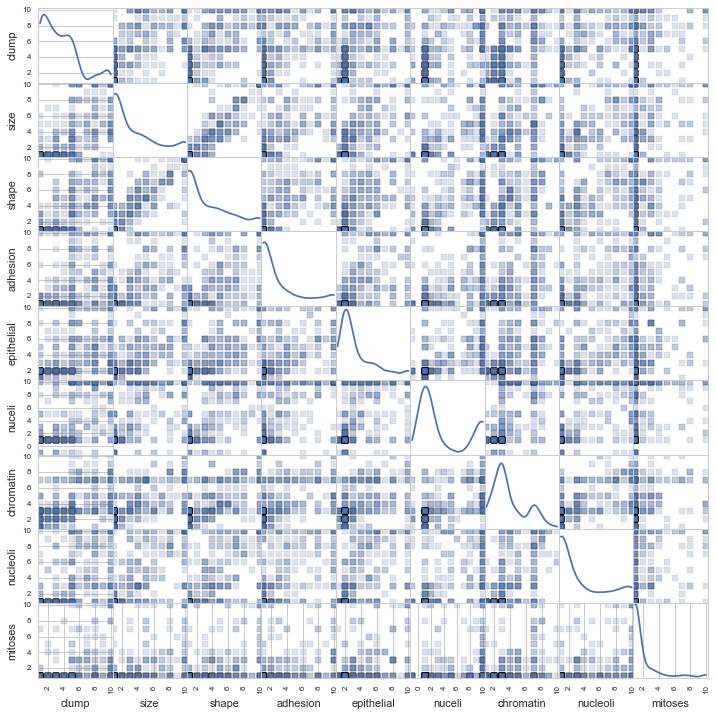

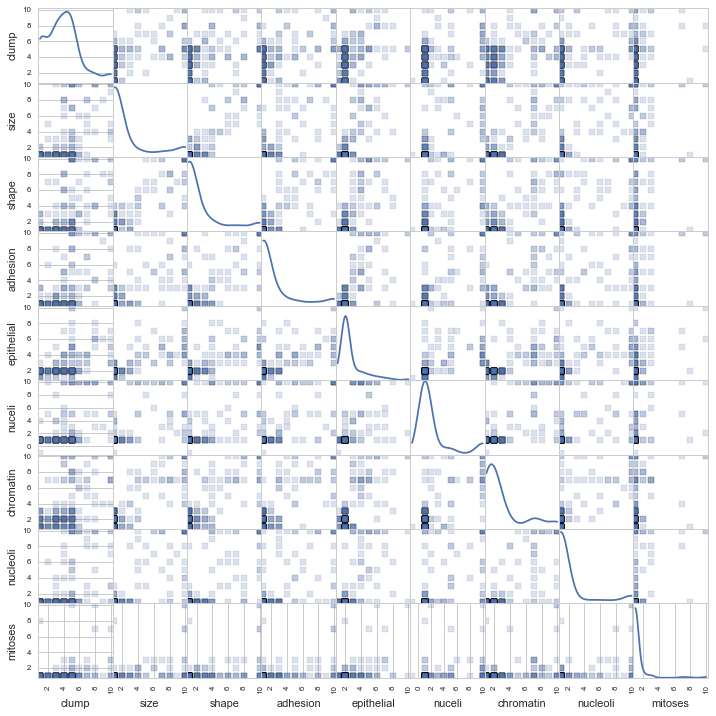

In [411]:
bins = np.arange(0, 11)
scatter_matrix(data.loc[:367, items], figsize=(12,12), grid=False,
               marker='s', s=40,
               alpha=0.2, diagonal='kde')
scatter_matrix(data.loc[489:, items], figsize=(12,12), grid=False,
               marker='s', s=40,
               alpha=0.2, diagonal='kde')
None
# Notes:
#  Shape and Size are correlated
#  Epithelial and adhesion show some correlation

In [523]:
def cv_it(df, isgood):
    X = ( (df.loc[isgood, good_items] - 
           np.mean(df.loc[isgood, good_items], axis=0)) 
          / np.std(df.loc[isgood, good_items], axis=0) ).as_matrix()
    print X.shape, np.max(df.loc[isgood, 'id'])
    y = df.loc[isgood, 'class']
    cv = sklearn.cross_validation.KFold(y.size, n_folds=5, random_state=0)
    r = sklearn.linear_model.LogisticRegressionCV(random_state=0)
#     r = sklearn.ensemble.RandomForestClassifier(random_state=0)
    tmp = sklearn.cross_validation.cross_val_score(r, X, y, cv=cv)
    print tmp.mean(), tmp.std()

cv_it(data, slice(0,210))
cv_it(data, slice(489,len(data)))
cv_it(data, slice(0,100))
cv_it(data, slice(len(data)-100,len(data)))


(211, 8) 1219525
0.943410852713 0.0406943218875
(210, 8) 13454352
0.995238095238 0.00952380952381
(101, 8) 1166654
0.921428571429 0.0663940002207
(100, 8) 13454352
1.0 0.0


In [524]:
print (0.995238095238-0.943410852713)/np.sqrt(0.0406943218875**2+0.00952380952381**2)
print (1-0.921428571429)/np.sqrt(0.0663940002207**2+0**2)

1.24006690146
1.183411578


#  T-SNE -- group users

In [494]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(X)

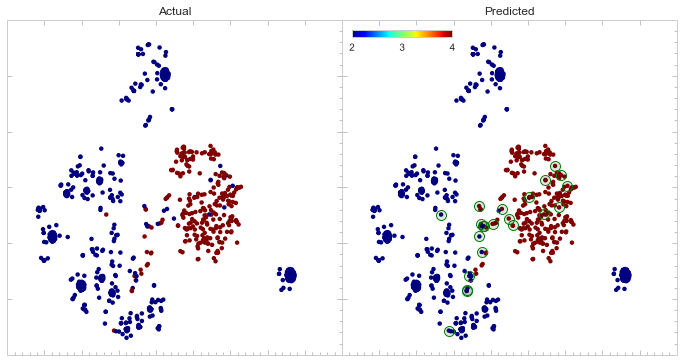

In [495]:
ax = setup(figsize=(12,6), subplt=(1,2,1), 
          xticks=False, yticks=False, title='Actual')
plt.scatter(Y[:,0], Y[:,1], c=y,
            lw=0, vmin=2, vmax=4, cmap=plt.cm.jet)
ax = setup(subplt=(1,2,2),xticks=False, yticks=False,
           hspace=0, wspace=0, title='Predicted')
sca = plt.scatter(Y[:,0], Y[:,1], c=y_pred_lr,
            lw=0, vmin=2, vmax=4, cmap=plt.cm.jet)

ii = np.where(y_pred_lr-y != 0)
plt.plot(Y[ii,0], Y[ii,1], 'o', color='none', 
         markerfacecolor=(0,0,0,0.1), 
         markeredgewidth=1,
         markersize=10,
         markeredgecolor='g', lw=4)


icolorbar(sca)

# ~5 clusters

In [472]:
isomap = sklearn.manifold.MDS()
Y = isomap.fit_transform(X)

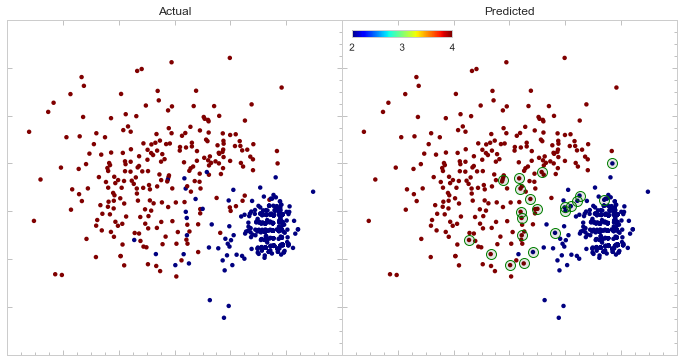

In [492]:
ax = setup(figsize=(12,6), subplt=(1,2,1), 
          xticks=False, yticks=False, title='Actual')
plt.scatter(Y[:,0], Y[:,1], c=y,
            lw=0, vmin=2, vmax=4, cmap=plt.cm.jet)

ax = setup(subplt=(1,2,2),xticks=False, yticks=False,
           hspace=0, wspace=0, title='Predicted')
sca = plt.scatter(Y[:,0], Y[:,1], c=y_pred_lr,
            lw=0, vmin=2, vmax=4, cmap=plt.cm.jet)

ii = np.where(y_pred_lr-y != 0)
plt.plot(Y[ii,0], Y[ii,1], 'o', color='none', 
         markerfacecolor=(0,0,0,0.1), 
         markeredgewidth=1,
         markersize=10,
         markeredgecolor='g', lw=4)

icolorbar(sca)
# ~5 clusters

In [513]:
connectivity = sklearn.neighbors.kneighbors_graph(X, n_neighbors=10, include_self=False)

ward = sklearn.cluster.AgglomerativeClustering(n_clusters=4, connectivity=connectivity,
                                               linkage='ward').fit(X)
label = ward.labels_


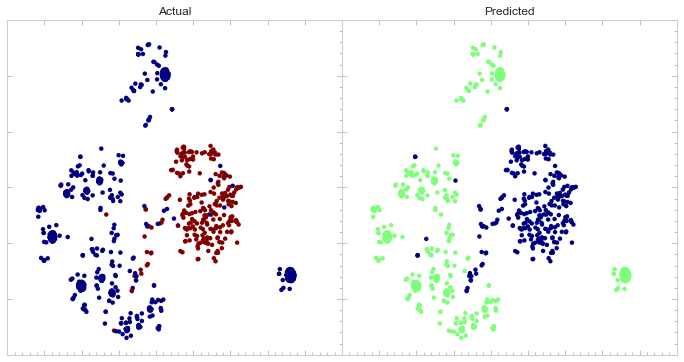

In [517]:
ax = setup(figsize=(12,6), subplt=(1,2,1), 
          xticks=False, yticks=False, title='Actual')
plt.scatter(Y[:,0], Y[:,1], c=y,
            lw=0, vmin=2, vmax=4, cmap=plt.cm.jet)
ax = setup(subplt=(1,2,2),xticks=False, yticks=False,
           hspace=0, wspace=0, title='Predicted')
sca = plt.scatter(Y[:,0], Y[:,1], c=label,
            lw=0, vmin=2, vmax=4, cmap=plt.cm.jet)

# Not Improving accuracy